# **CREATING STYLE FROM MONET PHOTO AND UTILISING IT FOR GENERATING IMAGES WITH SIMILAR STYLE**

In [ ]:
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [ ]:
#install Kaggle
!pip install -q kaggle

In [ ]:
#linking google drive for kaggle.json file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# creating creates a new directory named .kaggle.
! mkdir ~/.kaggle

#copies the Kaggle API credentials from the Google Drive to the newly created .kaggle directory.
!cp /content/drive/MyDrive/Colab_Notebooks/Kaggle_Credential/kaggle.json ~/.kaggle/

#command changes the permission of the copied Kaggle API credential file read and write the file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#command to downloads the dataset of the competition "I’m Something of a Painter Myself Use GANs to create art - will you be the next Monet?" from Kaggle.
! kaggle competitions download -c gan-getting-started

#command unzips the downloaded dataset.
! unzip -q gan-getting-started.zip

100% 367M/367M [00:19<00:00, 21.1MB/s]
100% 367M/367M [00:19<00:00, 19.4MB/s]


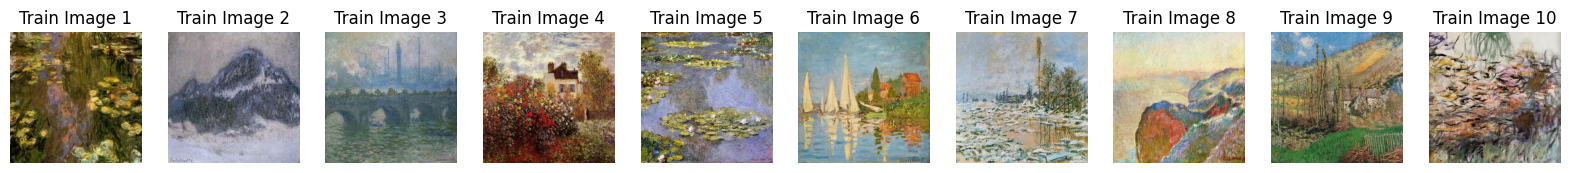

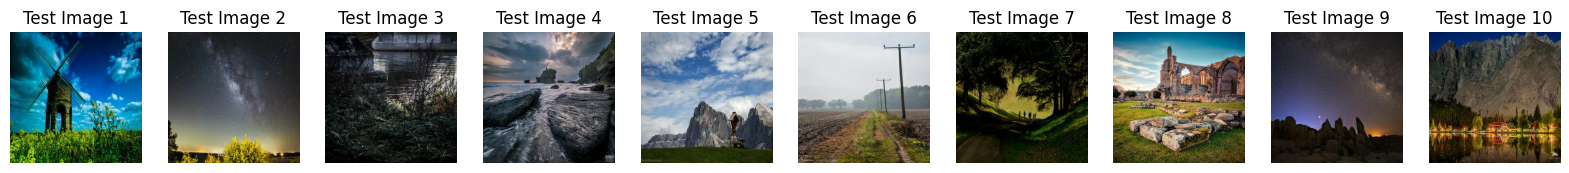

In [ ]:
# Set the paths to the train and test folders
train_folder = "/content/drive/MyDrive/Style image dataset/I’m Something of a Painter Myself/monet_jpg"
test_folder = "/content/drive/MyDrive/Style image dataset/I’m Something of a Painter Myself/photo_jpg"

# Get a list of all the image files in the train folder
train_files = [os.path.join(train_folder, f) for f in os.listdir(train_folder) if f.endswith('.jpg')]

# Get a list of all the image files in the test folder
test_files = [os.path.join(test_folder, f) for f in os.listdir(test_folder) if f.endswith('.jpg')]

# Choose 10 random images from the train set and 10 random images from the test set
random.shuffle(train_files)
random.shuffle(test_files)
train_img_paths = train_files[:10]
test_img_paths = test_files[:10]

# Load and plot the images from the train set
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes.flat):
    img_path = train_img_paths[i]
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    ax.imshow(np.uint8(img_array))
    ax.axis('off')
    ax.set_title('Train Image {}'.format(i + 1))
plt.show()

# Load and plot the images from the test set
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes.flat):
    img_path = test_img_paths[i]
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    ax.imshow(np.uint8(img_array))
    ax.axis('off')
    ax.set_title('Test Image {}'.format(i + 1))
plt.show()


In [ ]:
import os
import glob
from PIL import Image
import torchvision.transforms as transforms

# Data directory
data_dir = '/content/drive/MyDrive/Style image dataset/I’m Something of a Painter Myself'
monet_folder = os.path.join(data_dir, 'monet_jpg')
photo_folder = os.path.join(data_dir, 'photo_jpg')

# Check the number of images in each folder
monet_images = glob.glob(os.path.join(monet_folder, '*.*'))
photo_images = glob.glob(os.path.join(photo_folder, '*.*'))

print(f'Number of Monet images: {len(monet_images)}')
print(f'Number of Photo images: {len(photo_images)}')

# Define image transformations

img_height = 256
img_width = 256

transforms_list = [
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

# Apply transformations
data_transform = transforms.Compose(transforms_list)

# Example usage of transformations on a sample image
sample_image_path = monet_images[0]  # Change this to a valid image path
sample_image = Image.open(sample_image_path).convert('RGB')
sample_transformed_image = data_transform(sample_image)

# Print the shape of the transformed image
print(f'Transformed image shape: {sample_transformed_image.shape}')


Number of Monet images: 300
Number of Photo images: 7038
Transformed image shape: torch.Size([3, 256, 256])


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_) if transforms_ else None
        self.unaligned = unaligned
        self.mode = mode
        folder_A = 'monet_jpg' if mode == 'train' else 'monet_jpg'
        folder_B = 'photo_jpg' if mode == 'train' else 'photo_jpg'
        self.files_A = sorted(glob.glob(os.path.join(root, folder_A, '*.*')[:250] if mode == 'train' else os.path.join(root, folder_A, '*.*')))
        self.files_B = sorted(glob.glob(os.path.join(root, folder_B, '*.*')[:250] if mode == 'train' else os.path.join(root, folder_B, '*.*')))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)]).convert('RGB')
        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B) - 1)]).convert('RGB')
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)]).convert('RGB')

        if self.transform:
            item_A = self.transform(image_A)
            item_B = self.transform(image_B)
        else:
            item_A = transforms.ToTensor()(image_A)
            item_B = transforms.ToTensor()(image_B)

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))


In [ ]:
import os

# Get the number of available CPU cores
n_cpu = os.cpu_count()

# Print the number of CPU cores
print(f'Number of CPU cores: {n_cpu}')


Number of CPU cores: 2


In [ ]:
# DataLoader for validation
val_dataset = ImageDataset(data_dir, transforms_=transforms_list, unaligned=True, mode='test')

# Check if there are samples in the validation dataset
if len(val_dataset) > 0:
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=5,
        shuffle=True,
        num_workers=2  # Set to the number of available CPU cores
    )
    print(f'Validation DataLoader created with {len(val_dataset)} samples.')
else:
    print('Validation dataset is empty.')


Validation DataLoader created with 300 samples.


In [ ]:
# DataLoader for training
dataloader = DataLoader(
    ImageDataset(data_dir, transforms_=transforms_list, unaligned=True),
    batch_size=1,
    shuffle=True,
    num_workers=2  # Set to the number of available CPU cores
)

# DataLoader for validation
val_dataloader = DataLoader(
    ImageDataset(data_dir, transforms_=transforms_list, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=2  # Set to the number of available CPU cores
)


# Residual Block definition
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
# GeneratorResNet definition
class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()
        channels = input_shape[0]
        out_features = 64
        in_features = out_features
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()]

        # Unpacking
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [ ]:
# Discriminator definition
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        channels, height, width = input_shape
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

# Loss and model definitions
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

input_shape = (3, img_height, img_width)
n_residual_blocks = 9

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()

    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

In [ ]:
import itertools

# Initialize weights for the models
def weights_init_normal(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)

G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

# Set up optimizers
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

# Learning rate schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(5, 0, 3).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(5, 0, 3).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(5, 0, 3).step)

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Sample images function
def sample_images():
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A, fake_B, real_B, fake_A = map(lambda x: make_grid(x.type(Tensor), nrow=5, normalize=True), [imgs['A'], G_AB(imgs['A']).detach(), imgs['B'], G_BA(imgs['B']).detach()])
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1, 2, 0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show()

In [ ]:
temp_imgs = next(iter(val_dataloader))
G_AB.eval() # test mode
G_BA.eval() # test mode
print(temp_imgs['A'].shape)
print(temp_imgs['B'].shape)

torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])


In [ ]:
temp_real_A = temp_imgs['A'].type(Tensor) # A : monet
temp_fake_B = G_AB(temp_real_A).detach()
temp_real_B = temp_imgs['B'].type(Tensor) # B : photo
temp_fake_A = G_BA(temp_real_B).detach()

In [ ]:
print(temp_real_A.shape)
print(temp_fake_B.shape)
print(temp_real_B.shape)
print(temp_fake_A.shape)

torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])


In [ ]:
temp_real_A = make_grid(temp_real_A, nrow=5, normalize=True)
temp_real_B = make_grid(temp_real_B, nrow=5, normalize=True)
temp_fake_A = make_grid(temp_fake_A, nrow=5, normalize=True)
temp_fake_B = make_grid(temp_fake_B, nrow=5, normalize=True)

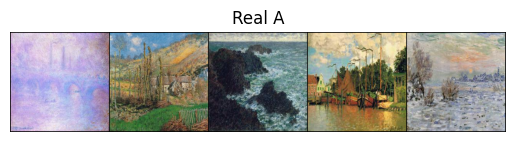

In [ ]:
plt.imshow(temp_real_A.cpu().permute(1,2,0))
plt.title('Real A')
plt.axis('off');

In [ ]:
print(temp_real_A.shape)
print(temp_fake_B.shape)
print(temp_real_B.shape)
print(temp_fake_A.shape)

torch.Size([3, 260, 1292])
torch.Size([3, 260, 1292])
torch.Size([3, 260, 1292])
torch.Size([3, 260, 1292])


In [ ]:
temp_image_grid = torch.cat((temp_real_A, temp_fake_A, temp_real_B, temp_fake_B), 1)
print(temp_image_grid.shape)

torch.Size([3, 1040, 1292])


In [ ]:
temp_image_grid.cpu().permute(1,2,0).shape

torch.Size([1040, 1292, 3])

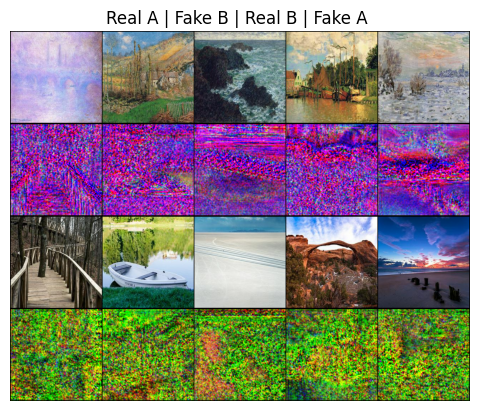

In [ ]:
plt.imshow(temp_image_grid.cpu().permute(1,2,0))
plt.title('Real A | Fake B | Real B | Fake A ')
plt.axis('off');

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings


In [ ]:
epoch = 0
n_epochs = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        # Set model input
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))).to(device)
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))).to(device)

        # Train Generators
        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN Loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle Loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total Loss
        loss_G = loss_GAN + (10.0 * loss_cycle) + (5.0 * loss_identity)

        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator A
        optimizer_D_A.zero_grad()
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        optimizer_D_A.step()

        # Train Discriminator B
        optimizer_D_B.zero_grad()
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        optimizer_D_B.step()

        # Total Discriminator Loss
        loss_D = (loss_D_A + loss_D_B) / 2



# Iterate through dataloader for a quick check
for i, batch in enumerate(dataloader):
    print(f'iter : {i}  A.size : {batch["A"].size()}')
    print(f'iter : {i}  B.size : {batch["B"].size()}')
    if i == 10:
        break

photo_dir = os.path.join(data_dir, 'photo_jpg')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]
print(len(files))


  0%|          | 0/300 [00:00<?, ?it/s]

<ipython-input-27-8e13fcfd88cb>:13: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))).to(device)


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

iter : 0  A.size : torch.Size([1, 3, 256, 256])
iter : 0  B.size : torch.Size([1, 3, 256, 256])
iter : 1  A.size : torch.Size([1, 3, 256, 256])
iter : 1  B.size : torch.Size([1, 3, 256, 256])
iter : 2  A.size : torch.Size([1, 3, 256, 256])
iter : 2  B.size : torch.Size([1, 3, 256, 256])
iter : 3  A.size : torch.Size([1, 3, 256, 256])
iter : 3  B.size : torch.Size([1, 3, 256, 256])
iter : 4  A.size : torch.Size([1, 3, 256, 256])
iter : 4  B.size : torch.Size([1, 3, 256, 256])
iter : 5  A.size : torch.Size([1, 3, 256, 256])
iter : 5  B.size : torch.Size([1, 3, 256, 256])
iter : 6  A.size : torch.Size([1, 3, 256, 256])
iter : 6  B.size : torch.Size([1, 3, 256, 256])
iter : 7  A.size : torch.Size([1, 3, 256, 256])
iter : 7  B.size : torch.Size([1, 3, 256, 256])
iter : 8  A.size : torch.Size([1, 3, 256, 256])
iter : 8  B.size : torch.Size([1, 3, 256, 256])
iter : 9  A.size : torch.Size([1, 3, 256, 256])
iter : 9  B.size : torch.Size([1, 3, 256, 256])
iter : 10  A.size : torch.Size([1, 3, 25

In [ ]:
photo_dir = os.path.join(data_dir, 'photo_jpg')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]
print(len(files))


7038


In [ ]:
save_dir = '/content/drive/MyDrive/Style image dataset/Style'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
generate_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_image = transforms.ToPILImage()
batch_size = 1
num_images_to_generate = 100  # Set the desired number of images to generate

G_BA.eval()
for i in range(min(len(files), num_images_to_generate), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+batch_size)):
        img = Image.open(files[j])
        img = generate_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)

    # generate
    fake_imgs = G_BA(imgs).detach().cpu()

    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)

        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(save_dir, name))


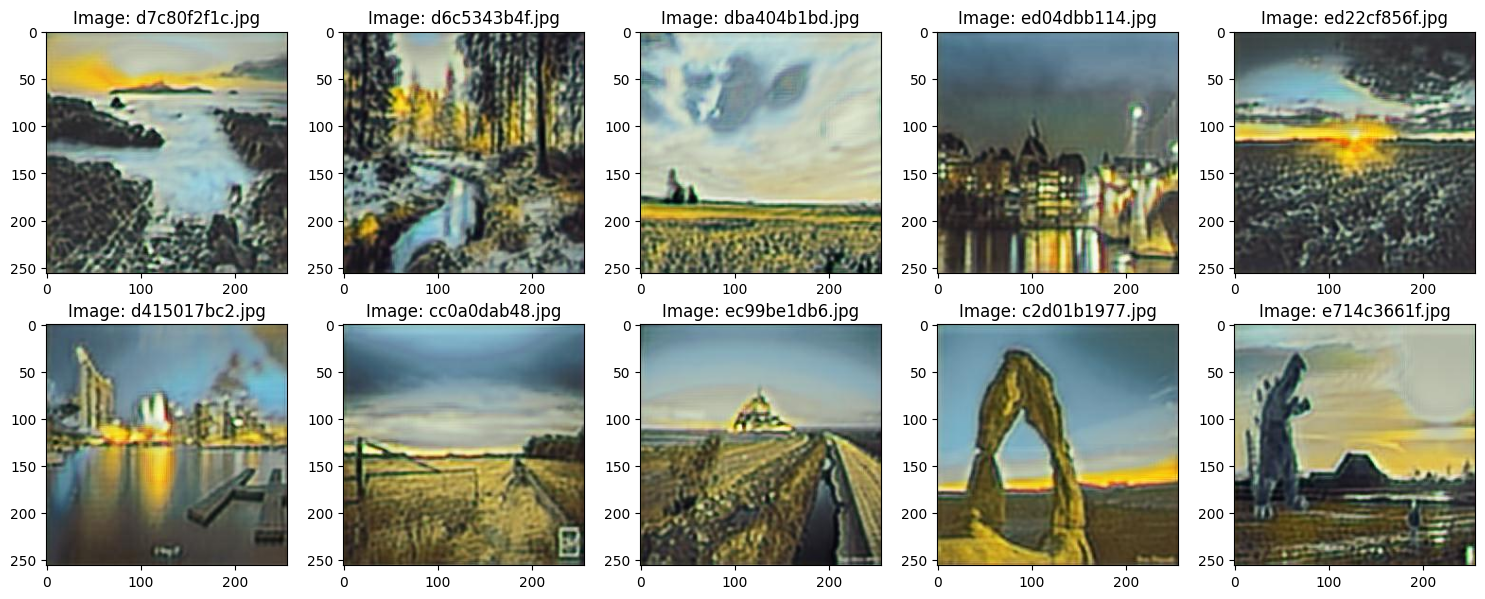

In [ ]:
import matplotlib.pyplot as plt

def print_images_with_names(image_paths):
    # Specify the number of columns in the subplot grid
    num_columns = 5

    # Calculate the number of rows needed
    num_rows = (len(image_paths) + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3*num_rows))

    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)

        # Plot the image with its name in a subplot
        row_index = i // num_columns
        col_index = i % num_columns
        axes[row_index, col_index].imshow(img)
        axes[row_index, col_index].set_title(f'Image: {os.path.basename(image_path)}')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


G_BA.eval()

# Specify the number of images to generate and display
num_images_to_generate = 10

# Generate and save images
generated_image_paths = []
for i in range(0, min(len(files), num_images_to_generate), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i + batch_size)):
        img = Image.open(files[j])
        img = generate_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)

    # generate
    fake_imgs = G_BA(imgs).detach().cpu()

    # save and collect image paths
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)

        img = to_image(img_arr)
        _, name = os.path.split(files[i + j])
        img_path = os.path.join(save_dir, name)
        img.save(img_path)
        generated_image_paths.append(img_path)

# Print the generated images with their names
print_images_with_names(generated_image_paths)


# **USING MODEL IMAGE GENERATION**

In [66]:
import tensorflow_hub as hub
import PIL.Image
import IPython.display as display

content_images = '/content/drive/MyDrive/New_dataset/content'
styled_images = '/content/drive/MyDrive/New_dataset/styled (1)'
content_path = [os.path.join(content_images, f) for f in os.listdir(content_images) if f.endswith('.jpg')]
style_path = [os.path.join(styled_images, f) for f in os.listdir(styled_images) if f.endswith('.jpg')]

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if isinstance(image, PIL.Image.Image):
        image = np.array(image)
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

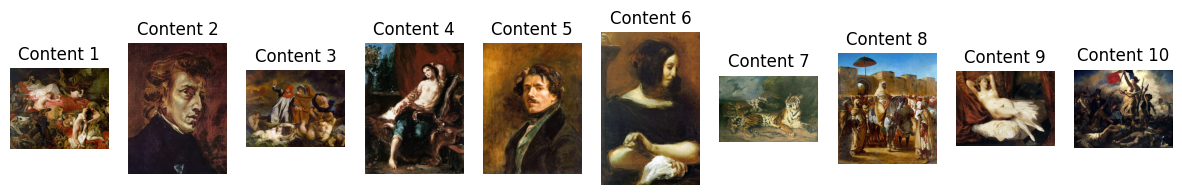

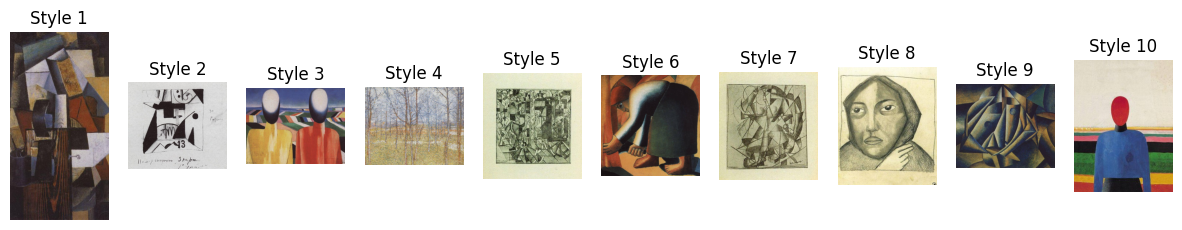

In [67]:
# Load and plot the content images
fig, axes = plt.subplots(1, len(content_path), figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    img_path = content_path[i]
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    ax.imshow(np.uint8(img_array))
    ax.axis('off')
    ax.set_title(f'Content {i + 1}')
plt.show()

# Load the first content image for further processing
content_image_path = content_path[0]
content_image = load_img(content_image_path)

# Load and plot the style images
fig, axes = plt.subplots(1, len(style_path), figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    img_path = style_path[i]
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    ax.imshow(np.uint8(img_array))
    ax.axis('off')
    ax.set_title(f'Style {i + 1}')
plt.show()



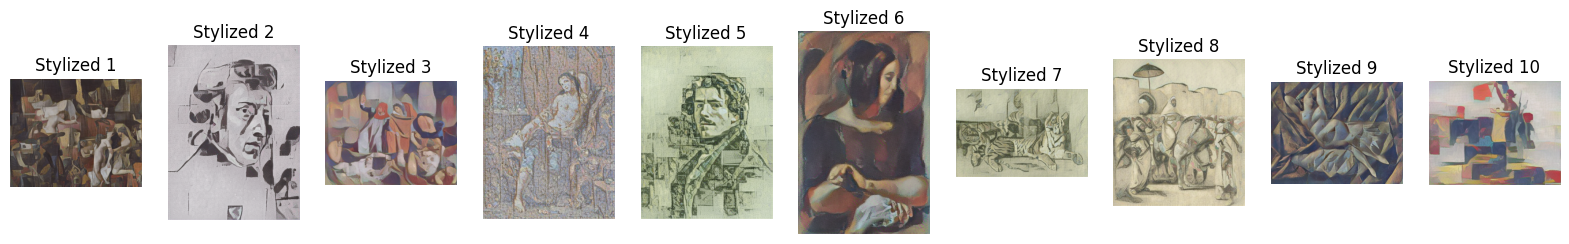

In [68]:
def stylize_image(content_path, style_path, hub_model):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    # Stylize the content image using the style image
    stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

    return tensor_to_image(stylized_image)

# Load the pre-trained model for arbitrary image stylization
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

# Stylize and display images
fig, axes = plt.subplots(1, len(content_path), figsize=(20, 5))  # Adjust the figsize here
for i, (content_img, style_img) in enumerate(zip(content_path, style_path)):
    stylized_img = stylize_image(content_img, style_img, hub_model)
    axes[i].imshow(stylized_img)
    axes[i].axis('off')
    axes[i].set_title(f'Stylized {i + 1}')

plt.show()


Stylistic Accuracy: 18.88936453213375
Content Preservation: [0.54428214]
Visual Appeal: 0.40325498580932617


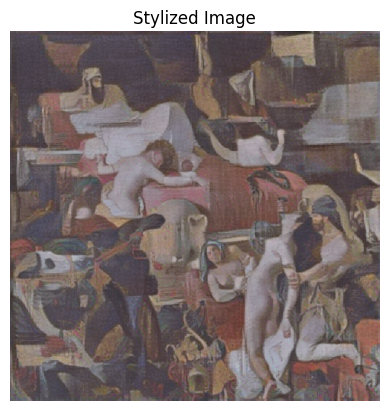

In [69]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img, target_dim=(512, 512)):
    max_dim = max(target_dim)
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, [target_dim[0], target_dim[1]])
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

def stylize_image(content_image_path, style_image_path, hub_model, target_dim=(512, 512)):
    content_img = load_img(content_image_path, target_dim)
    style_img = load_img(style_image_path, target_dim)
    stylized_image = hub_model(tf.constant(content_img), tf.constant(style_img))[0]
    return stylized_image

def evaluate_style_transfer(content_path, style_path, hub_model):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    stylized_image = stylize_image(content_path, style_path, hub_model)

    stylistic_accuracy = calculate_stylistic_accuracy(style_image, stylized_image)
    content_preservation = calculate_content_preservation(content_image, stylized_image)
    visual_appeal = calculate_visual_appeal(stylized_image)

    return stylistic_accuracy, content_preservation, visual_appeal

def calculate_stylistic_accuracy(style_image, stylized_image):
    mse = tf.reduce_mean(tf.square(style_image - stylized_image))
    return 1 / mse.numpy()  # Higher values indicate better stylistic accuracy

def calculate_content_preservation(content_image, stylized_image):
    ssim_index = tf.image.ssim(content_image, stylized_image, max_val=1.0)
    return ssim_index.numpy()  # Higher values indicate better content preservation

def calculate_visual_appeal(stylized_image):
    mean_intensity = tf.reduce_mean(stylized_image)
    return mean_intensity.numpy()  # Higher values indicate better visual appeal

# Evaluate style transfer metrics
stylistic_accuracy, content_preservation, visual_appeal = evaluate_style_transfer(
    content_path[0], style_path[0], hub_model
)

print(f'Stylistic Accuracy: {stylistic_accuracy}')
print(f'Content Preservation: {content_preservation}')
print(f'Visual Appeal: {visual_appeal}')

# Display the stylized image
stylized_img = stylize_image(content_path[0], style_path[0], hub_model, target_dim=(512, 512))
plt.imshow(tensor_to_image(stylized_img))
plt.axis('off')
plt.title('Stylized Image')
plt.show()

Content Image: Eugene_Delacroix_8.jpg, Style Image: Kazimir_Malevich_34.jpg
Stylistic Accuracy: 18.88936453213375
Content Preservation: [0.54428214]
Visual Appeal: 0.40325498580932617
--------------------------------------------------


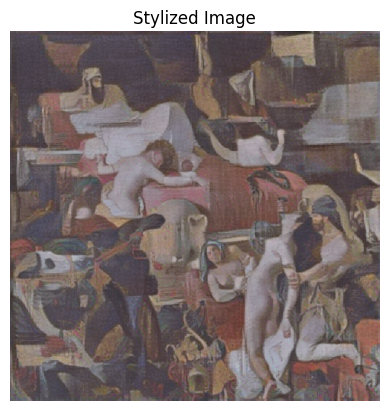

Content Image: Eugene_Delacroix_12.jpg, Style Image: Kazimir_Malevich_36.jpg
Stylistic Accuracy: 12.839890777765968
Content Preservation: [0.24343543]
Visual Appeal: 0.6734304428100586
--------------------------------------------------


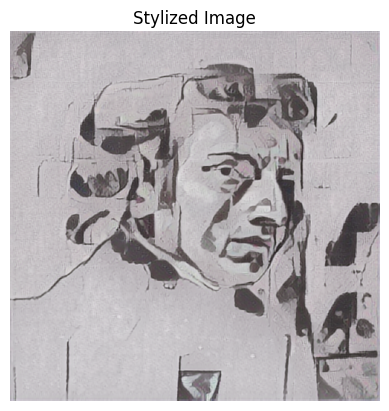

Content Image: Eugene_Delacroix_10.jpg, Style Image: Kazimir_Malevich_31.jpg
Stylistic Accuracy: 17.990356324862653
Content Preservation: [0.46175256]
Visual Appeal: 0.5067795515060425
--------------------------------------------------


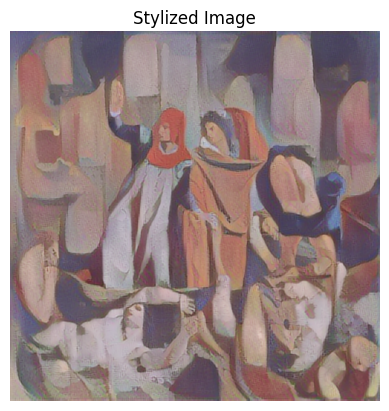

Content Image: Eugene_Delacroix_11.jpg, Style Image: Kazimir_Malevich_33.jpg
Stylistic Accuracy: 38.63422118178188
Content Preservation: [0.24781807]
Visual Appeal: 0.5870862603187561
--------------------------------------------------


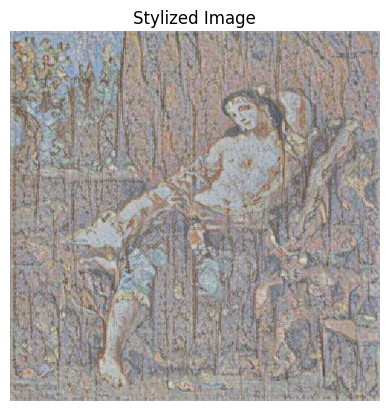

Content Image: Eugene_Delacroix_14.jpg, Style Image: Kazimir_Malevich_38.jpg
Stylistic Accuracy: 18.118769314881717
Content Preservation: [0.35784015]
Visual Appeal: 0.6277408599853516
--------------------------------------------------


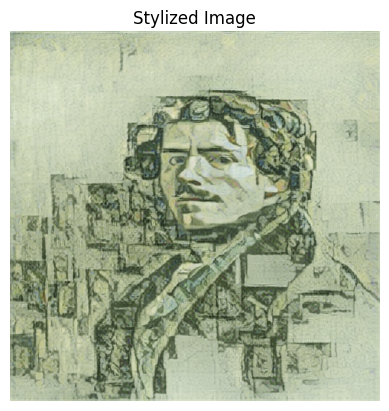

Content Image: Eugene_Delacroix_13.jpg, Style Image: Kazimir_Malevich_32.jpg
Stylistic Accuracy: 15.84053356899801
Content Preservation: [0.61630493]
Visual Appeal: 0.38316377997398376
--------------------------------------------------


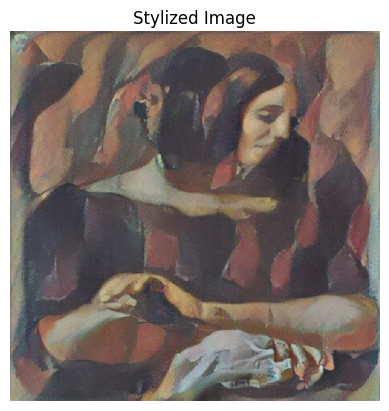

Content Image: Eugene_Delacroix_17.jpg, Style Image: Kazimir_Malevich_35.jpg
Stylistic Accuracy: 22.353297837587434
Content Preservation: [0.54970926]
Visual Appeal: 0.6156179308891296
--------------------------------------------------


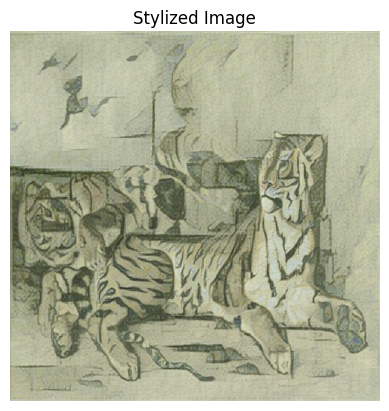

Content Image: Eugene_Delacroix_9.jpg, Style Image: Kazimir_Malevich_40.jpg
Stylistic Accuracy: 20.251324366541294
Content Preservation: [0.5036455]
Visual Appeal: 0.6618704199790955
--------------------------------------------------


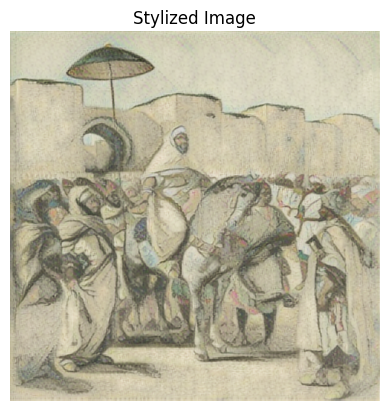

Content Image: Eugene_Delacroix_15.jpg, Style Image: Kazimir_Malevich_39.jpg
Stylistic Accuracy: 22.224833948437247
Content Preservation: [0.44836733]
Visual Appeal: 0.3994368314743042
--------------------------------------------------


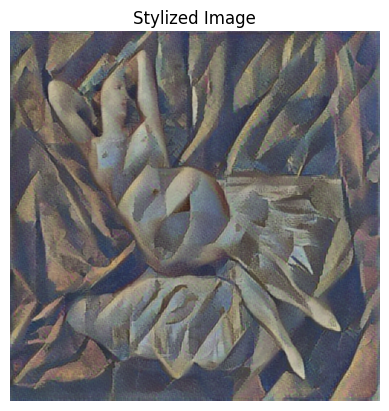

Content Image: Eugene_Delacroix_16.jpg, Style Image: Kazimir_Malevich_37.jpg
Stylistic Accuracy: 11.277562035833544
Content Preservation: [0.35369453]
Visual Appeal: 0.61076420545578
--------------------------------------------------


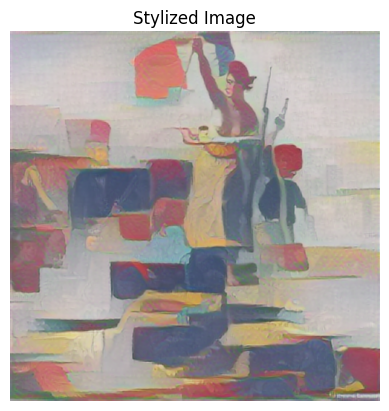

In [70]:
import os

# Define your content and style directories
content_images_dir = '/content/drive/MyDrive/New_dataset/content'
styled_images_dir = '/content/drive/MyDrive/New_dataset/styled (1)'

# List all content and style images
content_images = [os.path.join(content_images_dir, f) for f in os.listdir(content_images_dir) if f.endswith('.jpg')]
style_images = [os.path.join(styled_images_dir, f) for f in os.listdir(styled_images_dir) if f.endswith('.jpg')]

# Load the pre-trained model for arbitrary image stylization
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

def evaluate_style_transfer_all(content_images, style_images, hub_model):
    for content_path, style_path in zip(content_images, style_images):
        stylistic_accuracy, content_preservation, visual_appeal = evaluate_style_transfer(
            content_path, style_path, hub_model
        )

        print(f'Content Image: {os.path.basename(content_path)}, Style Image: {os.path.basename(style_path)}')
        print(f'Stylistic Accuracy: {stylistic_accuracy}')
        print(f'Content Preservation: {content_preservation}')
        print(f'Visual Appeal: {visual_appeal}')
        print('-' * 50)

        # Display the stylized image
        stylized_img = stylize_image(content_path, style_path, hub_model, target_dim=(512, 512))
        plt.imshow(tensor_to_image(stylized_img))
        plt.axis('off')
        plt.title('Stylized Image')
        plt.show()

# Evaluate style transfer metrics for all pairs
evaluate_style_transfer_all(content_images, style_images, hub_model)
